Epoch 1: Train Acc: 0.9023, Loss: 0.3366 | Val Acc: 0.9643, Loss: 0.1175
Epoch 2: Train Acc: 0.9695, Loss: 0.0997 | Val Acc: 0.9749, Loss: 0.0774
Epoch 3: Train Acc: 0.9791, Loss: 0.0663 | Val Acc: 0.9776, Loss: 0.0716
Epoch 4: Train Acc: 0.9841, Loss: 0.0507 | Val Acc: 0.9807, Loss: 0.0552
Epoch 5: Train Acc: 0.9870, Loss: 0.0410 | Val Acc: 0.9824, Loss: 0.0556


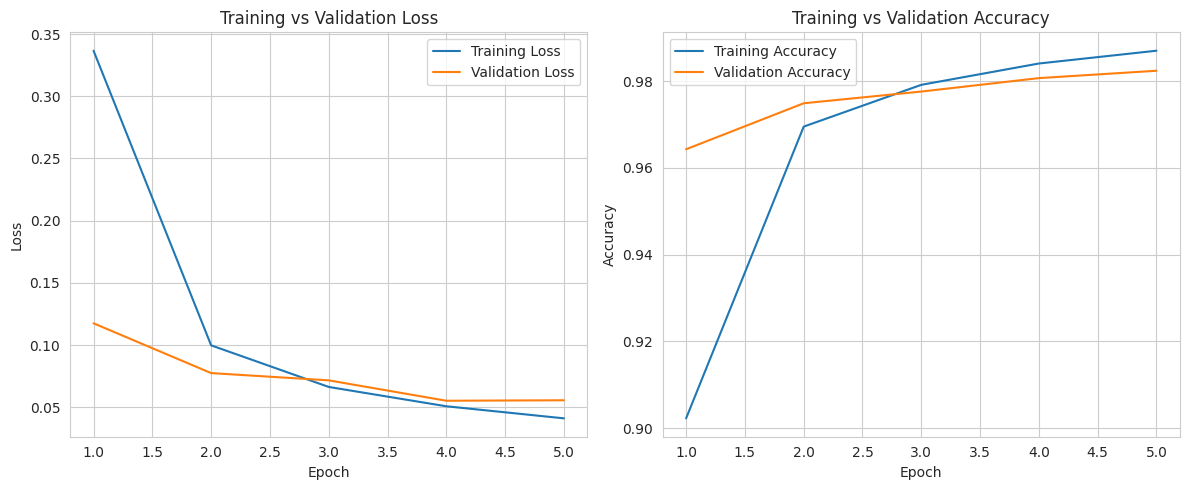

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,)),
])
train = torchvision.datasets.MNIST('', train=True, download=True, transform=transform)
test = torchvision.datasets.MNIST('', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train, shuffle=True, batch_size=100)
testloader = torch.utils.data.DataLoader(test, shuffle=False, batch_size=100)

class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.act1 = nn.Tanh()
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.act2 = nn.Tanh()
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(16, 120, kernel_size=5, stride=1, padding=0)
        self.act3 = nn.Tanh()

        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(120, 84)
        self.act4 = nn.Tanh()
        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        # input 1x28x28, output 6x28x28
        x = self.act1(self.conv1(x))
        # input 6x28x28, output 6x14x14
        x = self.pool1(x)
        # input 6x14x14, output 16x10x10
        x = self.act2(self.conv2(x))
        # input 16x10x10, output 16x5x5
        x = self.pool2(x)
        # input 16x5x5, output 120x1x1
        x = self.act3(self.conv3(x))
        # input 120x1x1, output 84
        x = self.act4(self.fc1(self.flat(x)))
        # input 84, output 10
        x = self.fc2(x)
        return x

model = LeNet5()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

n_epochs = 5
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for X_batch, y_batch in trainloader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * X_batch.size(0)
        correct += (torch.argmax(y_pred, 1) == y_batch).sum().item()
        total += y_batch.size(0)
    
    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for X_batch, y_batch in testloader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            val_correct += (torch.argmax(y_pred, 1) == y_batch).sum().item()
            val_total += y_batch.size(0)

    test_loss = val_loss / val_total
    test_accuracy = val_correct / val_total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch + 1}: "
          f"Train Acc: {train_accuracy:.4f}, Loss: {train_loss:.4f} | "
          f"Val Acc: {test_accuracy:.4f}, Loss: {test_loss:.4f}")

import matplotlib.pyplot as plt

epochs = range(1, n_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, test_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0,), (128,)),
])
train = torchvision.datasets.MNIST('', train=True, download=True, transform=transform)
test = torchvision.datasets.MNIST('', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train, shuffle=True, batch_size=100)
testloader = torch.utils.data.DataLoader(test, shuffle=True, batch_size=100)

class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.act1 = nn.Tanh()
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.act2 = nn.Tanh()
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(16, 120, kernel_size=5, stride=1, padding=0)
        self.act3 = nn.Tanh()

        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(1*1*120, 84)
        self.act4 = nn.Tanh()
        self.fc2 = nn.Linear(84, 10)
        
    def forward(self, x):
        # input 1x28x28, output 6x28x28
        x = self.act1(self.conv1(x))
        # input 6x28x28, output 6x14x14
        x = self.pool1(x)
        # input 6x14x14, output 16x10x10
        x = self.act2(self.conv2(x))
        # input 16x10x10, output 16x5x5
        x = self.pool2(x)
        # input 16x5x5, output 120x1x1
        x = self.act3(self.conv3(x))
        # input 120x1x1, output 84
        x = self.act4(self.fc1(self.flat(x)))
        # input 84, output 10
        x = self.fc2(x)
        return x

model = LeNet5()

optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

n_epochs = 10
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in trainloader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    model.eval()
    acc = 0
    count = 0
    for X_batch, y_batch in testloader:
        y_pred = model(X_batch)
        acc += (torch.argmax(y_pred, 1) == y_batch).float().sum()
        count += len(y_batch)
    acc = acc / count
    print("Epoch %d: model accuracy %.2f%%" % (epoch, acc*100))

Epoch 0: model accuracy 89.81%
Epoch 1: model accuracy 93.49%
Epoch 2: model accuracy 95.01%
Epoch 3: model accuracy 95.78%
Epoch 4: model accuracy 96.68%
Epoch 5: model accuracy 96.90%
Epoch 6: model accuracy 97.48%
Epoch 7: model accuracy 97.46%
Epoch 8: model accuracy 97.98%
Epoch 9: model accuracy 98.25%


In [41]:
import torch
from torch import nn
from torchvision.datasets import MNIST
import torchvision.transforms as TTransforms
from torch.utils.data import DataLoader

print(torch.__version__)

transform = TTransforms.Compose([
    TTransforms.ToTensor(),
    TTransforms.Resize((32,32))
])
trainSet = MNIST('', train = True, download = True, transform=transform)
testSet = MNIST('', train = False, download = True, transform=transform)
print(trainSet)
trainLoader = DataLoader(trainSet, batch_size = 64, shuffle = True)
testLoader = DataLoader(testSet, batch_size = 64, shuffle = True)

2.7.0+cu126
Dataset MNIST
    Number of datapoints: 60000
    Root location: 
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
           )


In [42]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 5),
            nn.ReLU(),
            nn.AvgPool2d(2),
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5),
            nn.ReLU(),
            nn.AvgPool2d(2),
            nn.Conv2d(in_channels = 16, out_channels = 120, kernel_size = 5)
        )
        self.head = nn.Sequential(
            nn.Linear(in_features = 120, out_features = 84),
            nn.ReLU(),
            nn.Linear(in_features = 84, out_features = 10),
        )
    def forward(self, x):
        out = self.encoder(x).flatten(start_dim = 1)
        return self.head(out)

In [43]:
model = LeNet()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
criterion = nn.CrossEntropyLoss()

In [44]:
from tqdm.notebook import tqdm

nEpochs = 5
trainLosses, trainAccuracies = [], []
testLosses, testAccuracies = [], []
pbar = tqdm(range(1, nEpochs + 1))
for epoch in pbar:
    trainLoss, trainAccuracy = 0.0, 0.0
    model.train()
    for images, labels in trainLoader:
        optimizer.zero_grad()
        predictions = model(images)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        trainLoss += loss.item() * images.shape[0]
        trainAccuracy += (predictions.argmax(dim = 1) == labels).sum().item()

    testLoss, testAccuracy = 0.0, 0.0
    model.eval()
    for images, labels in testLoader:
        predictions = model(images)
        loss = criterion(predictions, labels)
        testLoss += loss.item() * images.shape[0]
        testAccuracy += (predictions.argmax(dim = 1) == labels).sum().item()
    trainLoss /= len(trainLoader.dataset)
    testLoss /= len(testLoader.dataset)
    trainAccuracy /= len(trainLoader.dataset)
    testAccuracy /= len(testLoader.dataset)
    trainLosses += [trainLoss]
    trainAccuracies += [trainAccuracy]
    testLosses += [testLoss]
    testAccuracies += [testAccuracy]
    pbar.set_postfix({'train loss': trainLoss, 'test loss': testLoss, 'train accuracy' : trainAccuracy, 'test accuracy' : testAccuracy})

  0%|          | 0/5 [00:00<?, ?it/s]

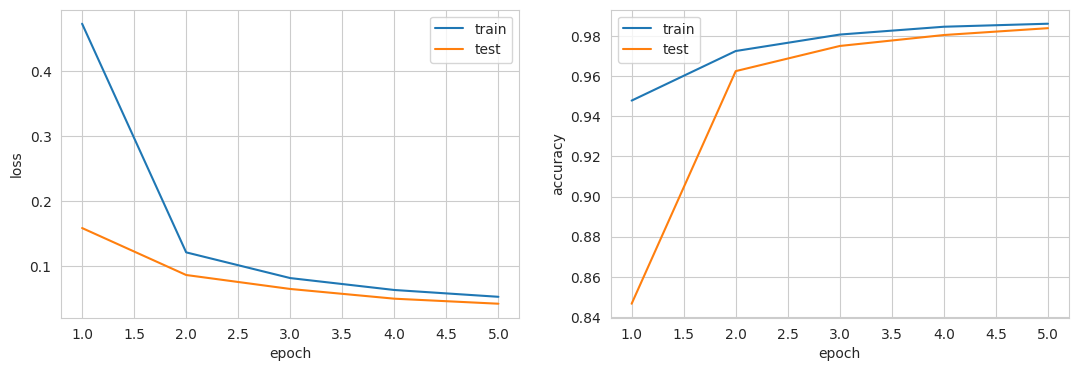

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output


sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 10})
def drowLosses(trainLosses, testLosses, testAccuracies, trainAccuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(trainLosses) + 1), trainLosses, label='train')
    axs[0].plot(range(1, len(testLosses) + 1), testLosses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(trainAccuracies) + 1), trainAccuracies, label='train')
    axs[1].plot(range(1, len(testAccuracies) + 1), testAccuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()
drowLosses(trainLosses, testLosses, trainAccuracies, testAccuracies)

In [46]:
print('train loss', trainLoss)
print('test loss', testLoss)
print('train accuracy',  trainAccuracy)
print('test accuracy', testAccuracy)

train loss 0.052354566329096755
test loss 0.04169472200646997
train accuracy 0.9838833333333333
test accuracy 0.9861


In [ ]:
import numpy as np
import struct
import gzip
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_data.shape
    out_h = (H + 2 * pad - filter_h) // stride + 1
    out_w = (W + 2 * pad - filter_w) // stride + 1

    img = np.pad(input_data, [(0, 0), (0, 0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N * out_h * out_w, -1)
    return col


def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_shape
    out_h = (H + 2 * pad - filter_h) // stride + 1
    out_w = (W + 2 * pad - filter_w) // stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2 * pad + stride - 1, W + 2 * pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]



class Conv2D:
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, pad=0):
        self.k = kernel_size
        self.stride = stride
        self.pad = pad
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.weights = np.random.randn(out_channels, in_channels, kernel_size, kernel_size) * 0.1
        self.biases = np.zeros(out_channels)

    def forward(self, x):
        self.input = x
        N, C, H, W = x.shape
        self.col = im2col(x, self.k, self.k, self.stride, self.pad)
        self.col_W = self.weights.reshape(self.out_channels, -1).T  # (C*k*k, out_channels)
        out = np.dot(self.col, self.col_W) + self.biases  # (N*out_h*out_w, out_channels)

        out_h = (H + 2 * self.pad - self.k) // self.stride + 1
        out_w = (W + 2 * self.pad - self.k) // self.stride + 1
        out = out.reshape(N, out_h, out_w, self.out_channels).transpose(0, 3, 1, 2)
        self.output = out  # <-- Добавь это
        return out

    def backward(self, d_out, lr):
        N, C, H, W = self.input.shape
        dout_reshaped = d_out.transpose(0, 2, 3, 1).reshape(-1, self.out_channels)

        dW = np.dot(self.col.T, dout_reshaped)  # (C*k*k, out_c)
        dW = dW.transpose(1, 0).reshape(self.out_channels, self.in_channels, self.k, self.k)

        db = np.sum(dout_reshaped, axis=0)

        dcol = np.dot(dout_reshaped, self.col_W.T)
        dx = col2im(dcol, self.input.shape, self.k, self.k, self.stride, self.pad)

        # Update
        self.weights -= lr * dW
        self.biases -= lr * db

        return dx


class AvgPool2D:
    def __init__(self, size):
        self.size = size

    def forward(self, x):
        self.input = x
        batch_size, c, h, w = x.shape
        out_h = h // self.size
        out_w = w // self.size
        output = np.zeros((batch_size, c, out_h, out_w))
        for i in range(out_h):
            for j in range(out_w):
                region = x[:, :, i * self.size:(i + 1) * self.size, j * self.size:(j + 1) * self.size]
                output[:, :, i, j] = np.mean(region, axis=(2, 3))
        self.output = output
        return output

    def backward(self, d_out, lr):
        batch_size, c, h, w = self.input.shape
        d_input = np.zeros_like(self.input)
        for i in range(h // self.size):
            for j in range(w // self.size):
                d = d_out[:, :, i, j][:, :, None, None] / (self.size * self.size)
                d_input[:, :, i * self.size:(i + 1) * self.size, j * self.size:(j + 1) * self.size] += d
        return d_input


class FullyConnected:
    def __init__(self, in_features, out_features):
        self.weights = np.random.randn(in_features, out_features) * 0.1
        self.biases = np.zeros((1, out_features))

    def forward(self, x):
        self.input = x
        return np.dot(x, self.weights) + self.biases

    def backward(self, d_out, lr):
        d_input = np.dot(d_out, self.weights.T)
        d_weights = np.dot(self.input.T, d_out)
        d_biases = np.sum(d_out, axis=0, keepdims=True)

        self.weights -= lr * d_weights
        self.biases -= lr * d_biases
        return d_input


class LeNet5Manual:
    def __init__(self):
        self.conv1 = Conv2D(1, 6, 5)
        self.pool1 = AvgPool2D(2)
        self.conv2 = Conv2D(6, 16, 5)
        self.pool2 = AvgPool2D(2)
        self.fc1 = FullyConnected(16 * 5 * 5, 120)
        self.fc2 = FullyConnected(120, 84)
        self.fc3 = FullyConnected(84, 10)

    def forward(self, x):
        out = self.conv1.forward(x)
        out = tanh(out)
        out = self.pool1.forward(out)
        out = self.conv2.forward(out)
        out = tanh(out)
        out = self.pool2.forward(out)
        out = out.reshape(out.shape[0], -1)
        self.fc1_out = tanh(self.fc1.forward(out))
        self.fc2_out = tanh(self.fc2.forward(self.fc1_out))
        out = self.fc3.forward(self.fc2_out)
        return softmax(out)

    def backward(self, d_out, lr):
        d = self.fc3.backward(d_out, lr)
        d = tanh_derivative(self.fc2_out) * d
        d = self.fc2.backward(d, lr)
        d = tanh_derivative(self.fc1_out) * d
        d = self.fc1.backward(d, lr)
        d = d.reshape(-1, 16, 5, 5)
        d = self.pool2.backward(d, lr)
        d = tanh_derivative(self.conv2.output) * d
        d = self.conv2.backward(d, lr)
        d = self.pool1.backward(d, lr)
        d = tanh_derivative(self.conv1.output) * d
        self.conv1.backward(d, lr)


def pad_images(images):
    return np.pad(images, ((0, 0), (0, 0), (2, 2), (2, 2)), mode='constant')


def load_images(filename):
    with gzip.open(filename, 'rb') as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        data = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols)
    return data


def load_labels(filename):
    with gzip.open(filename, 'rb') as f:
        magic, num = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels


def tanh(x):
    return np.tanh(x)


def tanh_derivative(x):
    return 1.0 - np.tanh(x) ** 2


def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)


def cross_entropy(predictions, labels):
    n = labels.shape[0]
    log_likelihood = -np.log(predictions[np.arange(n), labels] + 1e-9)
    return np.sum(log_likelihood) / n


def cross_entropy_derivative(predictions, labels):
    n = labels.shape[0]
    grad = predictions
    grad[np.arange(n), labels] -= 1
    return grad / n


model = LeNet5Manual()
lr = 0.01

epochs = 6
# padding 2 to 28x28 -> 32x32

train_images = load_images('train-images-idx3-ubyte.gz')

train_labels = load_labels('train-labels-idx1-ubyte.gz')

X_train = train_images[:, None, :, :].astype(np.float32) / 255.
X_train = pad_images(X_train)
y_train = train_labels

batch_size = 32
print(f"packs: {len(X_train) / batch_size}")

losses = list()
accuracies = list()

for epoch in range(epochs):
    total_loss = 0
    correct = 0
    # cnt = 1
    for i in range(0, len(X_train), batch_size):
        # print(f"pack {cnt}")
        x = X_train[i:i + batch_size]
        y = y_train[i:i + batch_size]
        out = model.forward(x)
        loss = cross_entropy(out, y)
        total_loss += loss
        pred = np.argmax(out)
        if pred == y[0]:
            correct += 1
        grad = cross_entropy_derivative(out, y)
        model.backward(grad, lr)
        # cnt += 1

    avg_loss = total_loss / len(X_train)
    acc = correct / len(X_train)
    losses.append(avg_loss)
    accuracies.append(acc)
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}, Accuracy: {acc:.4%}")

test_images = load_images('t10k-images-idx3-ubyte.gz')
test_labels = load_labels('t10k-labels-idx1-ubyte.gz')

X_test = test_images[:, None, :, :].astype(np.float32) / 255.0
X_test = np.pad(X_test, ((0, 0), (0, 0), (2, 2), (2, 2)), mode='constant')
y_test = test_labels

correct = 0
total = len(X_test)

for i in range(total):
    x = X_test[i:i + 1]
    y_true = y_test[i]
    y_pred = np.argmax(model.forward(x))
    if y_pred == y_true:
        correct += 1

accuracy = correct / total
print(f"Test accuracy: {accuracy:.2%}")

y_true = []
y_preds = []

for i in range(len(X_test)):
    x = X_test[i:i + 1]
    out = model.forward(x)
    pred = np.argmax(out)
    y_preds.append(pred)
    y_true.append(y_test[i])

cm = confusion_matrix(y_true, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix LeNet-5")
plt.show()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(1, len(losses) + 1), losses, color=color, label='val Loss')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper right')
ax1.set_title("val Loss")

color = 'tab:blue'
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)', color=color)
ax2.plot(range(1, len(accuracies) + 1), accuracies, color=color,
         label='val Accuracy')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper left')
ax2.set_title("val Accuracy")

plt.tight_layout()
plt.show()